# *_Sentimental analysis on GME tweets and relation to GME value_*

This notebook tests if the emotions of GameStop stock (GME)-related tweets were correlated to the GME value during the GME boom on 28th January 2021.

Therefore, we train a model to classify tweets into "positive" and "negative" based on emotions. <br/> Then we scrape tweets from the 28th January 2021 that contain GME-relevant hashtags. <br/>  Finally, we obtain GME stock market data from 28th January 2021 and graph it against GME tweet emotions.

The model training follows the sentimental analysis tutorial posted here: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

Note: ***this notebook is broken***! Extracting old stock market data is not free - at the point in time when I generated this notebook, I was not able to access the relevant stock market data anymore!

# Required modules

In [1]:
import re, string, random, nltk, json, glob, numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
from datetime import datetime

# 1. Make a model to classify tweets into "positive" and "negative" emotions

## 1.1 Download  example and denoising data

In [2]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/christopherhempel/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christopherhempel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christopherhempel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christopherhempel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christopherhempel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.2 Define functions

In [3]:
# Remove noise from tweets
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


# Get tweets from list for model 
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

## 1.3 Load in positive and negative tweet examples and clean data

In [4]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

## 1.4 Train Naive Bayes classifier model 

In [5]:
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

classifier = NaiveBayesClassifier.train(train_data)

print("Naive Bayes classifier model accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Naive Bayes classifier model accuracy is: 0.9953333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2086.7 : 1.0
                      :) = True           Positi : Negati =   1647.2 : 1.0
                     sad = True           Negati : Positi =     34.1 : 1.0
                     bam = True           Positi : Negati =     22.1 : 1.0
                follower = True           Positi : Negati =     19.6 : 1.0
                     x15 = True           Negati : Positi =     17.8 : 1.0
               community = True           Positi : Negati =     14.9 : 1.0
                  arrive = True           Positi : Negati =     12.6 : 1.0
                followed = True           Negati : Positi =     11.7 : 1.0
               goodnight = True           Positi : Negati =     11.6 : 1.0
None


# 1.5 Test classification on custom example tweet

In [6]:
custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print("Custom tweet: ", custom_tweet)
print("Classification: ", classifier.classify(dict([token, True] for token in custom_tokens)))

Custom tweet:  I ordered just once from TerribleCo, they screwed up, never used the app again.
Classification:  Negative


# 2. Scrape and classify GME tweets from 28th January 2021

## 2.1 Use APIFY (web scraping platform) to scrape tweets using GME-relevant hashtags into JSON files and save JSON files to working directory

Note: we did the scraping and the resulting JSON files are saved to the directory containing this Jupyter Notebook.
We scraped for tweets from 28th January 2021 containing the hashtags "gamestop", "gme", "robinhood", "shortsqueeze", and "wallstreetbets".

## 2.2 Import and clean scraped tweets

In [7]:
json_files = glob.glob("*.json")
twitter_files = np.zeros(len(json_files))

tweetsdict = [dict() for x in range(len(json_files))]

i = 0
for file in json_files:
  with open(file) as f:
    tweets = json.load(f)
    tweetsdict[i] = tweets
    i += 1

gme_tweets = []
for tweets in tweetsdict:
  for tweet in tweets:
    gme_tweets.append(tweet['full_text'])
    
print("Total number of tweets: ", len(gme_tweets))

Total number of tweets:  1954


## 2.3 Classify tweets and define ratio positive:negative tweets

In [8]:
tweet_classification=[]
for tweet in gme_tweets:
  tokens=remove_noise(word_tokenize(tweet))
  tweet_classification.append(classifier.classify(dict([token, True] for token in tokens)))
    
ratio_pos_neg=tweet_classification.count('Positive')/tweet_classification.count('Negative')

print(f"Ratio positive:negative tweets: {ratio_pos_neg}")

Ratio positive:negative tweets: 1.1147186147186148


# 3. Obtain GME stock market data from 28th January 2021 and graph it against GME tweet emotions

## 3.1 Download GME stock data

Note: the selected time frame is not the time frame in which the GME boom occurred - this data was not freely available anymore.

In [7]:
# Define the ticker symbol
tickerSymbol = 'GME'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get historical prices for this ticker
tickerDf = tickerData.history(period='1d', interval='15m', start='2022-01-10', end='2022-01-30')

#see your data
tickerDf.head()

JSONDecodeError: [Errno Expecting value] Forbidden: 0

## 3.2 Simulate volume of stock dataset

Note: we simulate stock dataset volume for the GME boom time frame.

In [10]:
time = pd.date_range("2021-01-27", periods=1200, freq="15T")
random_volume = random.sample(range(1000000, 9999999), 1200)
volume_df = pd.DataFrame({'time':time, 'volume':random_volume}).set_index('time')
volume_df.head()

,volume
time,
2021-01-27 00:00:00,7811437
2021-01-27 00:15:00,3763384
2021-01-27 00:30:00,9758962
2021-01-27 00:45:00,1428143
2021-01-27 01:00:00,9009122


## 3.3 Process tweet date and time

Note: this needs to be polished to accurately reflect times of the web-scraped tweets.

In [11]:
# Get times per tweet and make dataframe with times and classifications

tweet_times = []
for tweets in tweetsdict:
  for tweet in tweets:
    time=datetime.strptime(tweet['created_at'][2:19].replace("T", " "), '%y-%m-%d %H:%M:%S')
    tweet_times.append(time)

tweet_df = pd.DataFrame({'time':tweet_times, 'class':tweet_classification}).set_index('time')

tweet_df_counts = pd.get_dummies(tweet_df, columns=['class']).resample('15T').sum()

tweet_df_counts_clean = tweet_df_counts[(tweet_df_counts.T != 0).any()]

tweet_df_counts_clean.head()

,class_Negative,class_Positive
time,,
2021-01-27 19:45:00,1,0
2021-01-27 22:45:00,1,0
2021-01-28 00:15:00,1,0
2021-01-28 01:15:00,1,0
2021-01-28 02:15:00,1,1


## 3.4 Merge stock data and tweet data

In [12]:
mergedDf = tweet_df_counts_clean.merge(volume_df, left_index=True, right_index=True).reset_index()
mergedDf.head()

,time,class_Negative,class_Positive,volume
0,2021-01-27 19:45:00,1,0,2233097
1,2021-01-27 22:45:00,1,0,5867387
2,2021-01-28 00:15:00,1,0,2700942
3,2021-01-28 01:15:00,1,0,3497245
4,2021-01-28 02:15:00,1,1,1968285


## 3.5 Plot volume against positive and negative tweets

Note: this graph is made from simulated data, so it doesn't make sense.

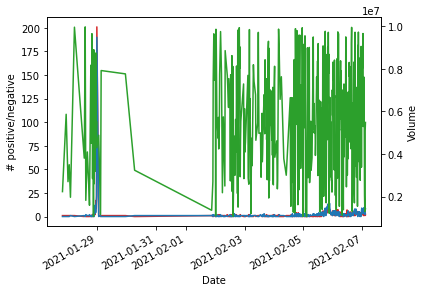

In [21]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('# positive/negative')
ax1.plot(mergedDf["time"], mergedDf["class_Negative"], color='tab:red')
ax1.plot(mergedDf["time"], mergedDf["class_Positive"], color='tab:blue')

ax2 = ax1.twinx() # instantiate a second axis that shares the same x-axis

ax2.set_ylabel('Volume')
ax2.plot(mergedDf["time"], mergedDf["volume"], color='tab:green')

fig.tight_layout() # otherwise the right y-label is slightly clipped
fig.autofmt_xdate() # automatically rotates x axis labels
fig.savefig("figure.png", facecolor='white')